In [16]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch.autograd import Variable
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, NN): 
        super(Net, self).__init__()

        self.input_layer = nn.Linear(2, NN)
        self.hidden_layer1 = nn.Linear(NN,int(NN/2)) 
        self.hidden_layer2 = nn.Linear(int(NN/2), int(NN/2))  
        self.output_layer = nn.Linear(int(NN/2), 1)
        

    def forward(self, x): # 一种特殊的方法 __call__() 回调
        out = torch.tanh(self.input_layer(x))
        out = torch.tanh(self.hidden_layer1(out))
        out = torch.tanh(self.hidden_layer2(out))
        out_final = self.output_layer(out)
        return out_final
#net(torch.cat([pt_t_bc_zeros, pt_x_bc_var], 1))

In [17]:
pred = Net(100)
# Define the optimizer
adam = torch.optim.Adam(pred.parameters(), lr=0.001)
#mse = torch.nn.MSELoss(reduction='mean') 

In [18]:
t_collocation = np.random.uniform(low=0.0, high=1.0, size=(200, 1))
x_collocation = np.random.uniform(low=-1.0, high=1.0, size=(200, 1))

t = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True)
x = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True)
#print(torch.cat([x, y],1))

spatial_coords = torch.cat([t, x],1)

In [20]:
# Define the neural network architecture
#NN = nn.Sequential(nn.Linear(2, neurons), nn.Sigmoid(), nn.Linear(neurons, 1, bias=True))

# Define our domian
# x = torch.linspace(0, 1, 1000)  # 100 spatial points
# y = torch.linspace(0, 1, 1000)
# spatial_coords = torch.stack((x, y), dim=1)


z_0 = torch.zeros_like(t)
z_1 = torch.ones_like(t)
z_2 = torch.full_like(t, -1)

bc_1 = torch.cat((z_0, x), dim=1)
bc_2 = torch.cat((t, z_1), dim=1)
bc_3 = torch.cat((t, z_2), dim=1)



def bc_function(t, x):
    # Define the bc function
    f = -torch.sin(np.pi * x)
    return f

# Define the boundary condition function (homogeneous Dirichlet boundary condition)
def boundary_condition(t, x):
    return torch.zeros_like(x)  # Zero value boundary condition

    
def loss_function(inputs):
    inputs.requires_grad_(True)  # Ensure that inputs require gradient

    grads_tx = torch.autograd.grad(outputs=pred(inputs), inputs=inputs, grad_outputs=torch.ones_like(pred(inputs)), create_graph=True, allow_unused=True)[0]
    grad_t = grads_tx[:, 0].unsqueeze(-1)
    grad_x = grads_tx[:, 1].unsqueeze(-1)

    u_tt = torch.autograd.grad(outputs=grad_t, inputs=inputs, grad_outputs=torch.ones_like(grad_t), create_graph=True, allow_unused=True)[0][:,0].unsqueeze(-1)
    u_xx = torch.autograd.grad(outputs=grad_x, inputs=inputs, grad_outputs=torch.ones_like(grad_x), create_graph=True, allow_unused=True)[0][:,1].unsqueeze(-1)

    pde_residual = grad_t + pred(inputs)*grad_x - (0.01/np.pi)*u_xx # Calculate PDE residual using only spatial coordinates

    # Calculate boundary residual
    boundary_residual_1 = pred(bc_1) - bc_function(t, x)
    boundary_residual_2 = pred(bc_2) - boundary_condition(t, x)
    boundary_residual_3 = pred(bc_3) - boundary_condition(t, x)


    # Total loss
    total_loss = torch.mean(pde_residual**2)+torch.mean(boundary_residual_1**2)+torch.mean(boundary_residual_2**2)+torch.mean(boundary_residual_3**2)
    
    return total_loss   

Epoch 1, Loss: 0.5580427050590515
Epoch 2, Loss: 0.48624610900878906
Epoch 3, Loss: 0.4632259011268616
Epoch 4, Loss: 0.4647608995437622
Epoch 5, Loss: 0.47122398018836975
Epoch 6, Loss: 0.4740816056728363
Epoch 7, Loss: 0.4723111093044281
Epoch 8, Loss: 0.4675014913082123
Epoch 9, Loss: 0.4617302119731903
Epoch 10, Loss: 0.45657938718795776
Epoch 11, Loss: 0.4529605507850647
Epoch 12, Loss: 0.4512087106704712
Epoch 13, Loss: 0.451145201921463
Epoch 14, Loss: 0.45212724804878235
Epoch 15, Loss: 0.45322275161743164
Epoch 16, Loss: 0.45355966687202454
Epoch 17, Loss: 0.45268985629081726
Epoch 18, Loss: 0.45073091983795166
Epoch 19, Loss: 0.4482344686985016
Epoch 20, Loss: 0.44589778780937195
Epoch 21, Loss: 0.44425833225250244
Epoch 22, Loss: 0.44348010420799255
Epoch 23, Loss: 0.44332191348075867
Epoch 24, Loss: 0.4433158338069916
Epoch 25, Loss: 0.4430481791496277
Epoch 26, Loss: 0.4423525929450989
Epoch 27, Loss: 0.4413140118122101
Epoch 28, Loss: 0.4401354193687439
Epoch 29, Loss: 0.

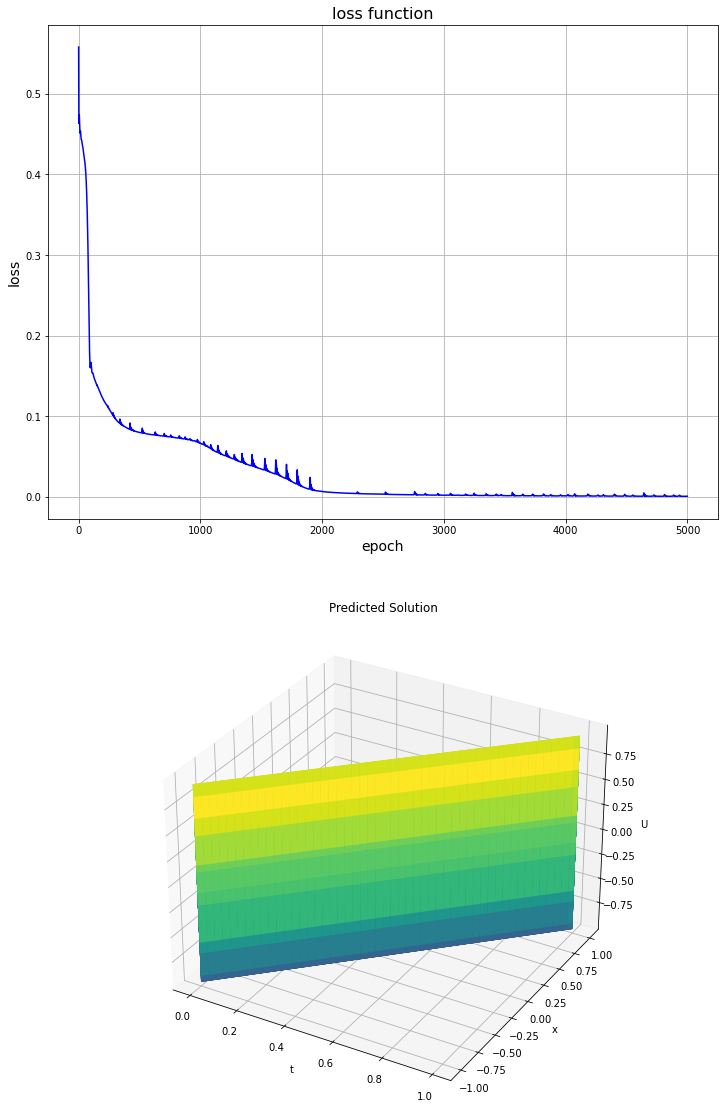

In [21]:
def train(optimizer, epochs):
    lossList = []
    epochList = []

    for epoch in range(epochs):
        #total_loss = 0
        optimizer.zero_grad()
        loss_val = loss_function(spatial_coords)  # Calculate the loss
        loss_val.backward() # Backpropagation
        optimizer.step()
        print(f"Epoch {epoch + 1}, Loss: {loss_val.detach().numpy()}") 
        #total_loss += loss_val.item()
        lossList.append(loss_val.detach().numpy())
        epochList.append(epoch)   
        
    
    uNN = pred(spatial_coords).detach().numpy()
    #pred_grid = uNN.view(100, 100).numpy()

    fig = plt.figure(figsize=(12, 20))

    
    ax_t = np.linspace(0, 1, 200)
    ax_x = np.linspace(-1, 1, 200)
    

    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(epochList, lossList, linestyle='-', color='blue')
    ax1.set_title('loss function', fontsize=16)
    ax1.set_xlabel('epoch', fontsize=14)
    ax1.set_ylabel('loss', fontsize=14)
    ax1.grid(True)

    ax2 = fig.add_subplot(2, 1, 2, projection='3d')
    ax2.plot_surface(ax_t, ax_x, uNN, cmap='viridis')
    ax2.set_xlabel('t')
    ax2.set_ylabel('x')
    ax2.set_zlabel('U')
    ax2.set_title('Predicted Solution')

    
    plt.savefig('loss.png')
    #plt.tight_layout()
    plt.show()
    

# Train the neural network
train(adam, 5000)